# Source Localisation Evaluation

In [1]:
EXPORT_LATEX = True

%matplotlib inline 
# %matplotlib notebook would provide interactive plots

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from mthesis.helpers import *  # all functions are in this package

## All Data 

In [2]:
df = load_all_data()
dft = df

In [3]:
print("SUMMARY:")
dft = df
summary = dft.groupby('n-sources').agg({'x1':'count', 'err-mean':np.mean, 'percent-matched':np.mean}).rename(columns={'x1':'n'})
print(summary.transpose())

print_summary(dft, verbose=False)
print("OVERVIEW OF SAMPLE SIZES PER EVALUATION:")
dfp = df.pivot_table("x1", index=["n-sources"], columns=["reflect-order", "T60", "em", "md", "SNR","wd","var-val","var-fixed"], aggfunc='count').transpose()
print(dfp)

# if EXPORT_LATEX:
#     summary.transpose().to_latex("".join([PATH_LATEX_TABLES, 'summary-all.tex']), column_format="rrrrrrr", bold_rows=True)

SUMMARY:
n-sources          2    3    4    5    6    7
n               8920 8920 8920 8920 8920 8920
err-mean        0.15 0.26 0.36 0.42 0.47 0.46
percent-matched 0.78 0.71 0.65 0.60 0.55 0.52
DATA FROM:  {'T60', 'var-fixed', 'reflect-order', 'worst-case', 'noise', 'em-iterations', 'base', 'wd', 'min-distance'}
n-sources          2    3    4    5    6    7
n               8920 8920 8920 8920 8920 8920
em-iterations   6.78 6.78 6.78 6.78 6.78 6.78
T60             0.35 0.35 0.35 0.35 0.35 0.35
SNR             1.51 1.51 1.51 1.51 1.51 1.51
md              0.48 0.48 0.48 0.48 0.48 0.48
reflect-order   2.20 2.20 2.20 2.20 2.20 2.20
var-fixed       0.15 0.15 0.15 0.15 0.15 0.15
var-val         0.47 0.47 0.47 0.47 0.47 0.47
err-mean        0.15 0.26 0.36 0.42 0.47 0.46
percent-matched 0.78 0.71 0.65 0.60 0.55 0.52
NOTE: Data contains range of md (['0.1', '0.3', '0.5', '1.0'], n=[400, 200, 8220, 100])
NOTE: Data contains range of wd (['1.2', '1.3', '1.5'], n=[8120, 400, 400])
NOTE: Data contai

# <font color='green'>--- PRINTING RESULTS TO TIKZ AND LATEX STARTS HERE ---</font>

## Fixed EM-Iterations

In [4]:
# Manipulate Data
var = "em"
dft = df
dft = dft[dft["description"]=="em-iterations"]
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.3]
# dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
print_summary(dft)

DATA FROM:  {'em-iterations'}
n-sources          2    3    4    5    6    7
n               1200 1200 1200 1200 1200 1200
em-iterations   6.83 6.83 6.83 6.83 6.83 6.83
T60             0.30 0.30 0.30 0.30 0.30 0.30
SNR                0    0    0    0    0    0
md              0.50 0.50 0.50 0.50 0.50 0.50
reflect-order      3    3    3    3    3    3
var-fixed          0    0    0    0    0    0
var-val         0.10 0.10 0.10 0.10 0.10 0.10
err-mean        0.14 0.23 0.32 0.40 0.49 0.47
percent-matched 0.78 0.72 0.68 0.62 0.56 0.53
NOTE: Data contains range of em (['1.0', '2.0', '3.0', '5.0', '10.0', '20.0'], n=200)



In [5]:
print("SAMPLE SIZE:")
dfp = dft.pivot_table("x1", index=["n-sources"], columns=var, aggfunc='count').transpose()
print(dfp)

print("\nMEAN ERROR:")
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()
print(dfp)
# if EXPORT_LATEX:
#     dfp.to_latex("".join([PATH_LATEX_TABLES, 'results-{}.tex'.format(var)]), column_format="lcccccc", bold_rows=True)

SAMPLE SIZE:
n-sources    2    3    4    5    6    7
em                                     
1          200  200  200  200  200  200
2          200  200  200  200  200  200
3          200  200  200  200  200  200
5          200  200  200  200  200  200
10         200  200  200  200  200  200
20         200  200  200  200  200  200

MEAN ERROR:
n-sources    2    3    4    5    6    7
em                                     
1         0.19 0.37 0.48 0.50 0.65 0.60
2         0.17 0.23 0.39 0.47 0.52 0.50
3         0.14 0.22 0.29 0.43 0.46 0.44
5         0.12 0.20 0.25 0.36 0.46 0.44
10        0.13 0.20 0.25 0.30 0.39 0.43
20        0.08 0.18 0.28 0.31 0.45 0.41


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


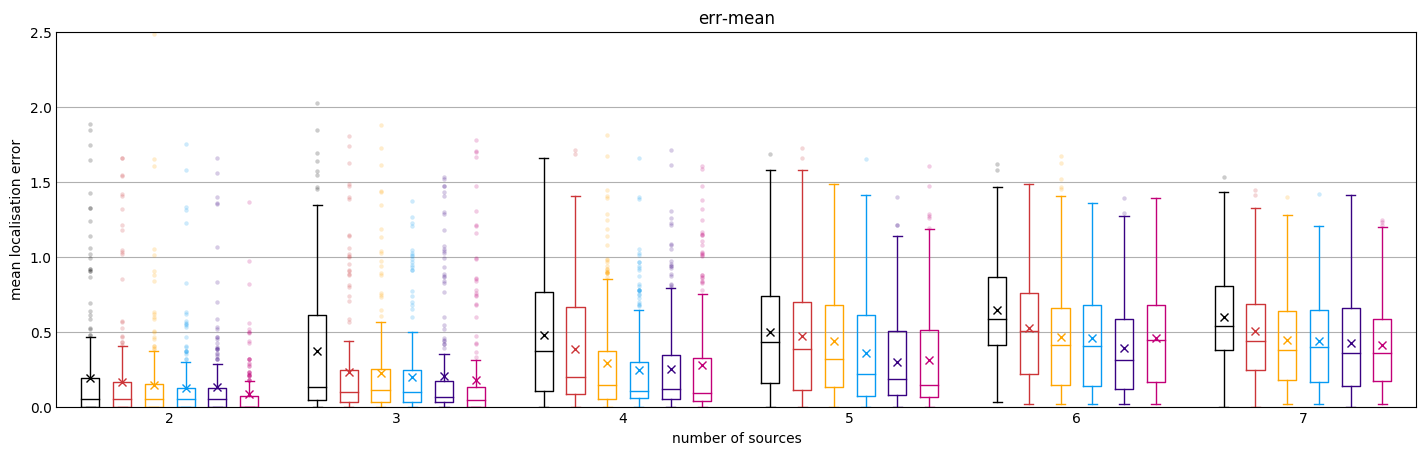

In [6]:
# Joint Boxplot, grouped
fig = figure(figsize=(17,5)); ax  = fig.add_subplot(111)

idx=0
for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    bp = dftt.boxplot("err-mean", by=["n-sources"], ax=ax, **boxplot_args)
    style_boxplot(bp, None, idx, len(dfp.index.values))
    idx+=1

if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-{}.tex'.format(var)]), strict=True, wrap=False)

## T60

In [34]:
# Manipulate Data
var = "T60"
dft = df
dft = dft[dft["reflect-order"]==-1]
# dft = dft[dft["T60"]==0.3]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
print_summary(dft)

DATA FROM:  {'T60', 'reflect-order'}
n-sources          2    3    4    5    6    7
n                550  550  550  550  550  550
em-iterations      5    5    5    5    5    5
T60             0.49 0.49 0.49 0.49 0.49 0.49
SNR                0    0    0    0    0    0
md              0.50 0.50 0.50 0.50 0.50 0.50
reflect-order     -1   -1   -1   -1   -1   -1
var-fixed          0    0    0    0    0    0
var-val         0.10 0.10 0.10 0.10 0.10 0.10
err-mean        0.23 0.41 0.56 0.63 0.63 0.58
percent-matched 0.70 0.62 0.55 0.48 0.44 0.43
NOTE: Data contains range of T60 (['0.0', '0.3', '0.6', '0.9'], n=[100, 100, 250, 100])



In [8]:
print("SAMPLE SIZE:")
dfp = dft.pivot_table("x1", index=["n-sources"], columns=[var], aggfunc='count').transpose()
print(dfp)

print("\nMEAN ERROR:")
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()
print(dfp)
if EXPORT_LATEX:
    dfp.to_latex("".join([PATH_LATEX_TABLES, 'results-{}.tex'.format(var)]), column_format="lrrrrrr", bold_rows=True)

SAMPLE SIZE:
n-sources    2    3    4    5    6    7
T60                                    
0          100  100  100  100  100  100
0.30       100  100  100  100  100  100
0.60       250  250  250  250  250  250
0.90       100  100  100  100  100  100

MEAN ERROR:
n-sources    2    3    4    5    6    7
T60                                    
0         0.04 0.04 0.11 0.22 0.23 0.30
0.30      0.11 0.21 0.34 0.36 0.40 0.35
0.60      0.23 0.50 0.70 0.80 0.83 0.75
0.90      0.56 0.74 0.89 0.88 0.77 0.68


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


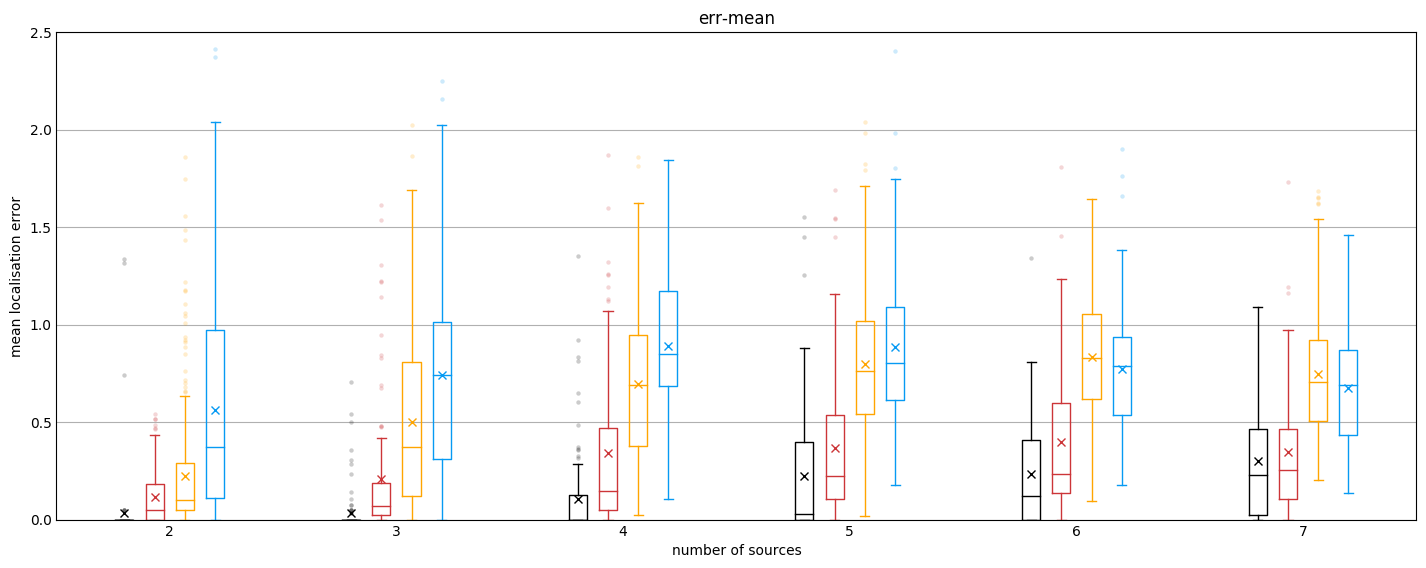

In [9]:
# Joint Boxplot, grouped
fig = figure(figsize=(17,6.5)); ax  = fig.add_subplot(111)

idx=0
for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    bp = dftt.boxplot("err-mean", by=["n-sources"], ax=ax, **boxplot_args)
    style_boxplot(bp, None, idx, len(dfp.index.values))
    idx+=1

if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-{}.tex'.format(var)]), strict=True, wrap=False)

# Min-Distance 

In [10]:
var="md"
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.0]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
# dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
# print_summary(dft)

In [11]:
print("SAMPLE SIZE:")
dfp = dft.pivot_table("x1", index=["n-sources"], columns=["md"], aggfunc='count').transpose()
print(dfp)

print("\nMEAN ERROR:")
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=["md"], aggfunc='mean').transpose()
print(dfp)

SAMPLE SIZE:
n-sources    2    3    4    5    6    7
md                                     
0.10       100  100  100  100  100  100
0.30       100  100  100  100  100  100
0.50       300  300  300  300  300  300
1          100  100  100  100  100  100

MEAN ERROR:
n-sources        2    3    4    5    6    7
md                                         
0.10          0.02 0.12 0.18 0.18 0.24 0.24
0.30          0.05 0.09 0.15 0.23 0.25 0.20
0.50          0.03 0.08 0.13 0.18 0.25 0.30
1         6.33e-03 0.14 0.37 0.45 0.62 0.72


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


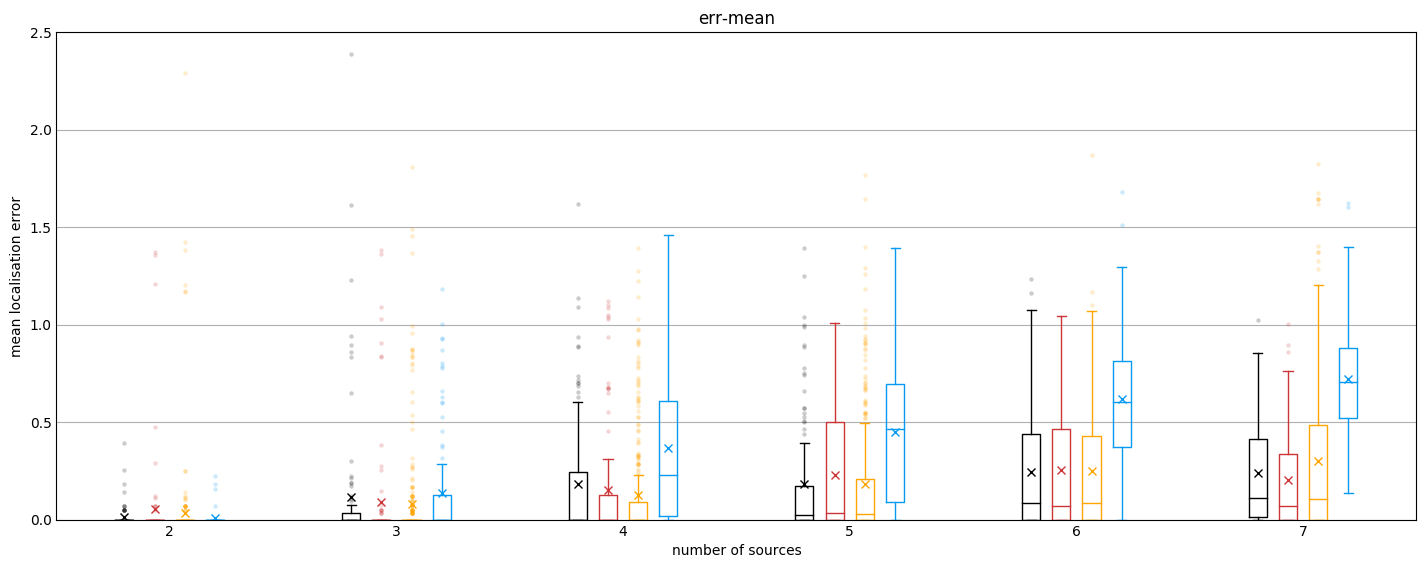

In [12]:
# Joint Boxplot, grouped
fig = figure(figsize=(17,6.5)); ax  = fig.add_subplot(111)

idx=0
for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    bp = dftt.boxplot("err-mean", by=["n-sources"], ax=ax, **boxplot_args)
    style_boxplot(bp, None, idx, len(dfp.index.values))
    idx+=1

if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-{}.tex'.format(var)]), strict=True, wrap=False)

# Reflect Order

In [32]:
# Manipulate Data
var = "reflect-order"
dft = df
# dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.6]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
# print_summary(dft)

In [33]:
print("SAMPLE SIZE:")
dfp = dft.pivot_table("x1", index=["n-sources"], columns=["reflect-order"], aggfunc='count').transpose()
print(dfp)

print("\nMEAN ERROR:")
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=["reflect-order"], aggfunc='mean').transpose()
print(dfp)

SAMPLE SIZE:
n-sources        2    3    4    5    6    7
reflect-order                              
-1             250  250  250  250  250  250
1              250  250  250  250  250  250
3              250  250  250  250  250  250

MEAN ERROR:
n-sources        2    3    4    5    6    7
reflect-order                              
-1            0.23 0.50 0.70 0.80 0.83 0.75
1             0.12 0.17 0.25 0.35 0.43 0.43
3             0.15 0.29 0.40 0.51 0.60 0.56


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


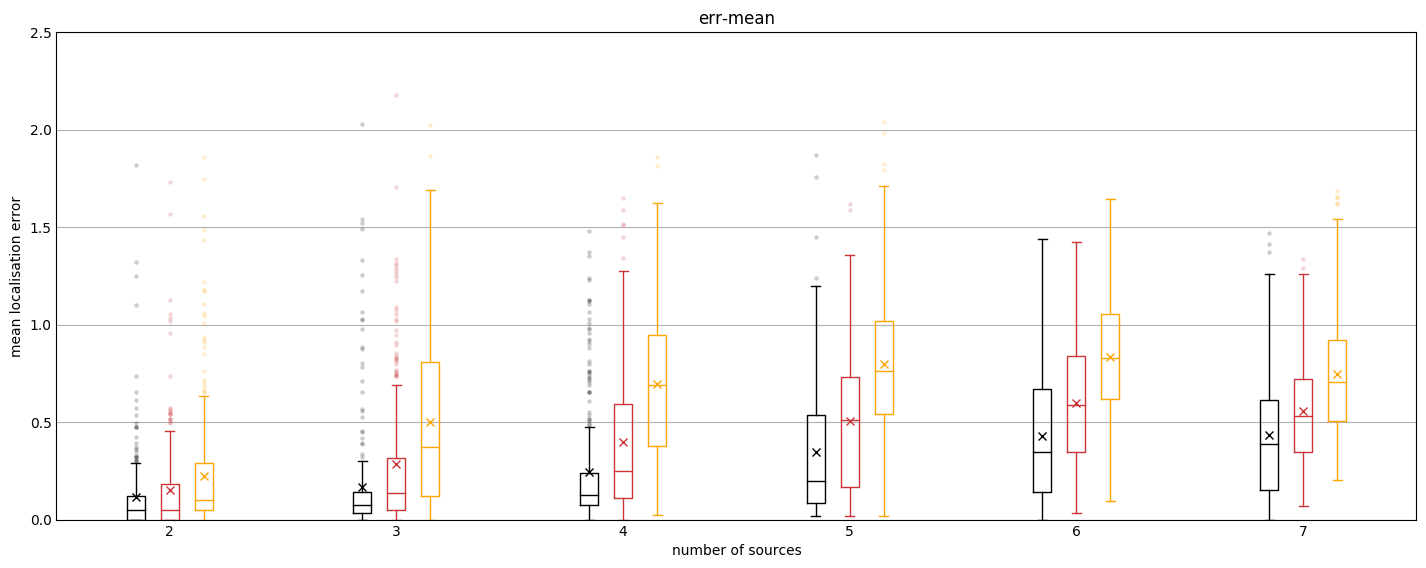

In [31]:
# Joint Boxplot, grouped
fig = figure(figsize=(17,6.5)); ax  = fig.add_subplot(111)

idx=0
for val in [1,3,-1]:
    dftt = dft[dft[var]==val]
    bp = dftt.boxplot("err-mean", by=["n-sources"], ax=ax, **boxplot_args)
    style_boxplot(bp, None, idx, len(dfp.index.values))
    idx+=1

if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-{}.tex'.format(var)]), strict=True, wrap=False)

## SNR

In [16]:
var = "SNR"
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.3]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
# dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
dft = dft[dft["description"]=="noise"]
print_summary(dft)

DATA FROM:  {'noise'}
n-sources          2    3    4    5    6    7
n               1000 1000 1000 1000 1000 1000
em-iterations      5    5    5    5    5    5
T60             0.30 0.30 0.30 0.30 0.30 0.30
SNR               12   12   12   12   12   12
md              0.50 0.50 0.50 0.50 0.50 0.50
reflect-order      3    3    3    3    3    3
var-fixed          0    0    0    0    0    0
var-val         0.10 0.10 0.10 0.10 0.10 0.10
err-mean        0.15 0.27 0.38 0.42 0.44 0.40
percent-matched 0.74 0.66 0.60 0.55 0.50 0.47
NOTE: Data contains range of SNR (['0.0', '5.0', '10.0', '15.0', '30.0'], n=200)



In [17]:
print("SAMPLE SIZE:")
dfp = dft.pivot_table("x1", index=["n-sources"], columns=[var], aggfunc='count').transpose()
print(dfp)

print("\nMEAN ERROR:")
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()
print(dfp)

SAMPLE SIZE:
n-sources    2    3    4    5    6    7
SNR                                    
0          200  200  200  200  200  200
5          200  200  200  200  200  200
10         200  200  200  200  200  200
15         200  200  200  200  200  200
30         200  200  200  200  200  200

MEAN ERROR:
n-sources    2    3    4    5    6    7
SNR                                    
0         0.10 0.19 0.30 0.33 0.36 0.31
5         0.17 0.42 0.56 0.58 0.56 0.52
10        0.17 0.34 0.45 0.45 0.47 0.46
15        0.16 0.25 0.36 0.44 0.46 0.42
30        0.13 0.16 0.24 0.32 0.36 0.32


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


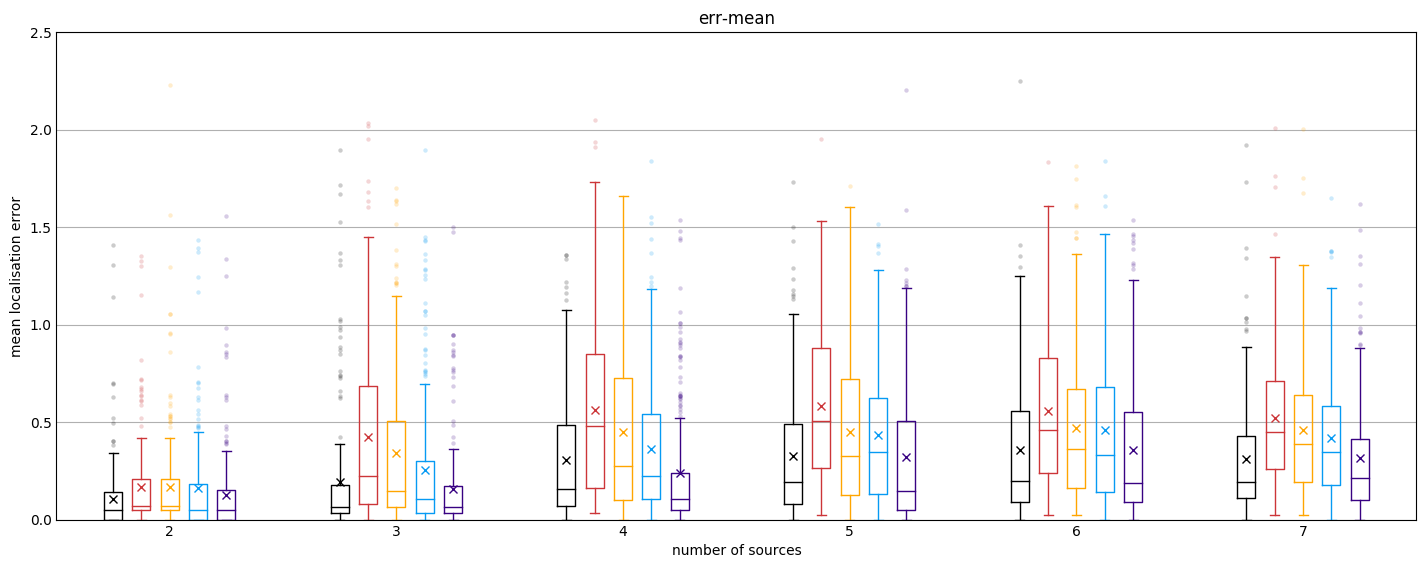

In [18]:
# Joint Boxplot, grouped
fig = figure(figsize=(17,6.5)); ax  = fig.add_subplot(111)

idx=0
for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    bp = dftt.boxplot("err-mean", by=["n-sources"], ax=ax, **boxplot_args)
    style_boxplot(bp, None, idx, len(dfp.index.values))
    idx+=1

if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-{}.tex'.format(var)]), strict=True, wrap=False)

# Wall distance

In [19]:
var = "wd"
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.3]
dft = dft[dft["em"]==5]
# dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
print_summary(dft)
# dfp = df.pivot_table("err-mean", index=["description", "wd"], columns="n-sources", aggfunc='mean').transpose()
# dfp.boxplot(column=("n-sources"))

DATA FROM:  {'T60', 'noise', 'em-iterations'}
n-sources          2    3    4    5    6    7
n               1000 1000 1000 1000 1000 1000
em-iterations      5    5    5    5    5    5
T60             0.30 0.30 0.30 0.30 0.30 0.30
SNR                0    0    0    0    0    0
md              0.50 0.50 0.50 0.50 0.50 0.50
reflect-order      3    3    3    3    3    3
var-fixed          0    0    0    0    0    0
var-val         0.10 0.10 0.10 0.10 0.10 0.10
err-mean        0.10 0.18 0.26 0.33 0.38 0.36
percent-matched 0.82 0.76 0.70 0.64 0.61 0.56
NOTE: Data contains range of wd (['1.2', '1.3', '1.5'], n=[600, 200, 200])



In [20]:
print("SAMPLE SIZE:")
dfp = dft.pivot_table("x1", index=["n-sources"], columns=[var], aggfunc='count').transpose()
print(dfp)

print("\nMEAN ERROR:")
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()
print(dfp)

SAMPLE SIZE:
n-sources    2    3    4    5    6    7
wd                                     
1.20       600  600  600  600  600  600
1.30       200  200  200  200  200  200
1.50       200  200  200  200  200  200

MEAN ERROR:
n-sources    2    3    4    5    6    7
wd                                     
1.20      0.12 0.18 0.29 0.33 0.39 0.36
1.30      0.08 0.22 0.26 0.32 0.42 0.37
1.50      0.09 0.13 0.18 0.32 0.34 0.35


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


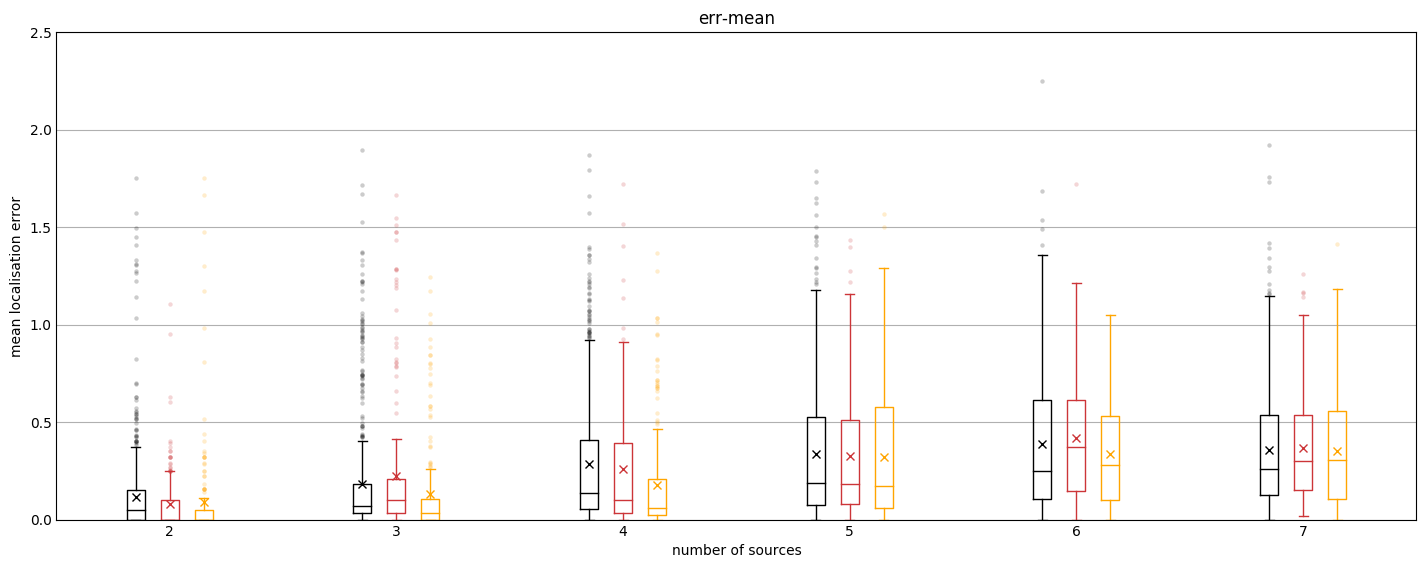

In [21]:
# Joint Boxplot, grouped
fig = figure(figsize=(17,6.5)); ax  = fig.add_subplot(111)

idx=0
for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    bp = dftt.boxplot("err-mean", by=["n-sources"], ax=ax, **boxplot_args)
    style_boxplot(bp, None, idx, len(dfp.index.values))
    idx+=1

if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-{}.tex'.format(var)]), strict=True, wrap=False)

# Best Case Scenario vs. Worst Case Scenario

In [22]:
var = "wd"
dfts = []

print("BEST CASE SCENARIO:")
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==0]
dft = dft[dft["T60"]==0.0]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.5]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
print_summary(dft)
dfts.append(dft)

print("BASE SCENARIO:")
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.3]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
print_summary(dft)
dfts.append(dft)

print("WORST CASE SCENARIO:")
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==-1]
dft = dft[dft["T60"]==0.9]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==5]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
print_summary(dft)
dfts.append(dft)

print("GUESSING:")
dft = matlab2pandas(dirname='_guessing', save_to=path.join(PATH_ROOT, '_guessing'), summary=True)
dfts.append(dft)

BEST CASE SCENARIO:
DATA FROM:  {'wd'}
n-sources              2    3    4    5    6    7
n                    200  200  200  200  200  200
em-iterations          5    5    5    5    5    5
T60                    0    0    0    0    0    0
SNR                    0    0    0    0    0    0
md                  0.50 0.50 0.50 0.50 0.50 0.50
reflect-order          0    0    0    0    0    0
var-fixed              0    0    0    0    0    0
var-val             0.10 0.10 0.10 0.10 0.10 0.10
err-mean        1.12e-03 0.06 0.11 0.15 0.20 0.25
percent-matched     1.00 0.96 0.93 0.91 0.87 0.83

BASE SCENARIO:
DATA FROM:  {'T60', 'noise', 'em-iterations'}
n-sources          2    3    4    5    6    7
n                600  600  600  600  600  600
em-iterations      5    5    5    5    5    5
T60             0.30 0.30 0.30 0.30 0.30 0.30
SNR                0    0    0    0    0    0
md              0.50 0.50 0.50 0.50 0.50 0.50
reflect-order      3    3    3    3    3    3
var-fixed          0    0  

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


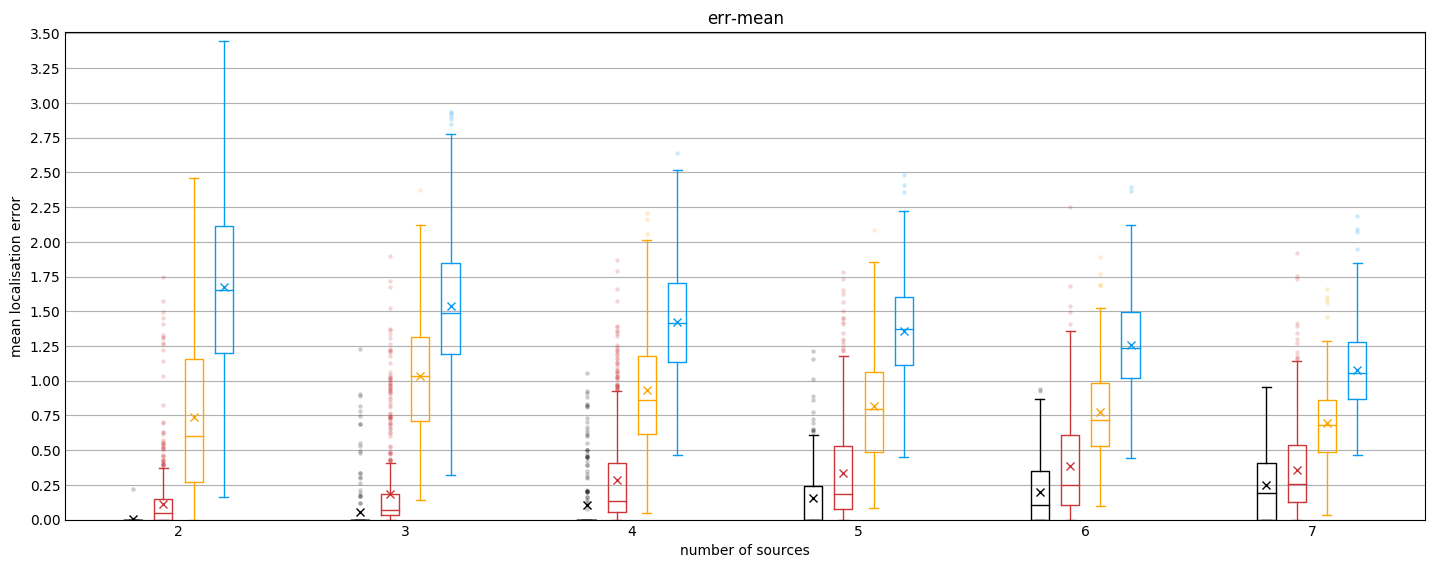

In [23]:
# Joint Boxplot, grouped
fig = figure( figsize=(17,6.5) ); ax  = fig.add_subplot(111)
idx=0
for dft in dfts:
    dftt = dft
    bp = dftt.boxplot("err-mean", by=["n-sources"], ax=ax, **boxplot_args)
    style_boxplot(bp, None, idx, 4)
    idx+=1
# adjust axis to larger values of guessing and worst case scenario
ax.set_ylim([0,3.51])
ax.set_yticks(np.arange(0,3.51,0.25))

if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-best-case.tex'.format(var)]), strict=True, wrap=False)

# Variance Analysis

In [24]:
# Manipulate Data
dft = df.copy()
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.3]
dft = dft[dft["em"]==10]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
print_summary(dft)

DATA FROM:  {'T60', 'var-fixed', 'em-iterations'}
n-sources          2    3    4    5    6    7
n               2000 2000 2000 2000 2000 2000
em-iterations     10   10   10   10   10   10
T60             0.30 0.30 0.30 0.30 0.30 0.30
SNR                0    0    0    0    0    0
md              0.50 0.50 0.50 0.50 0.50 0.50
reflect-order      3    3    3    3    3    3
var-fixed       0.65 0.65 0.65 0.65 0.65 0.65
var-val         1.74 1.74 1.74 1.74 1.74 1.74
err-mean        0.11 0.21 0.29 0.36 0.45 0.43
percent-matched 0.80 0.72 0.65 0.62 0.55 0.52
NOTE: Data contains range of var-fixed (['0.0', '1.0'], n=[700, 1300])
NOTE: Data contains range of var-val (['0.1', '0.5', '1.0', '2.0', '3.0', '5.0'], n=[500, 250, 450, 250, 200, 350])



In [25]:
# Sample Sizes
dfp = dft.pivot_table("x1", index=["n-sources"], columns=["var-val","var-fixed"], aggfunc='count').transpose()
print(dfp)
init_vars = set([x[0] for x in dfp.index.values])
var_fixed = set([x[1] for x in dfp.index.values])

n-sources            2    3    4    5    6    7
var-val var-fixed                              
0.10    0          300  300  300  300  300  300
        1          200  200  200  200  200  200
0.50    0           50   50   50   50   50   50
        1          200  200  200  200  200  200
1       0          100  100  100  100  100  100
        1          350  350  350  350  350  350
2       0          100  100  100  100  100  100
        1          150  150  150  150  150  150
3       0           50   50   50   50   50   50
        1          150  150  150  150  150  150
5       0          100  100  100  100  100  100
        1          250  250  250  250  250  250


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


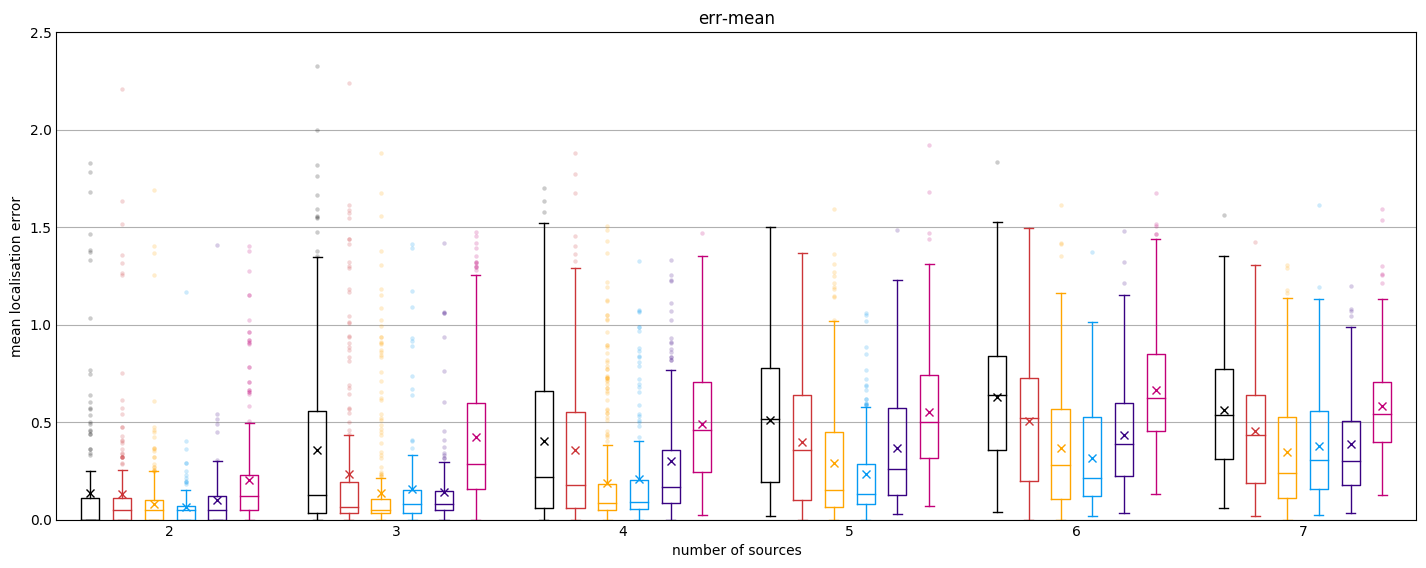

In [26]:
var = 'var-val'
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()

# Joint Boxplot, grouped
fig = figure( figsize=(17,6.5) ); ax  = fig.add_subplot(111)

idx=0
for val in sorted(init_vars):
    dftt = dft[dft[var]==val]
    dftt = dftt[dftt['var-fixed']==1]
    bp = dftt.boxplot("err-mean", by=["n-sources"], ax=ax, **boxplot_args)
    style_boxplot(bp, None, idx, len(init_vars))
    idx+=1
if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-{}.tex'.format(var)]), strict=True, wrap=False)

TypeError: object of type 'function' has no len()

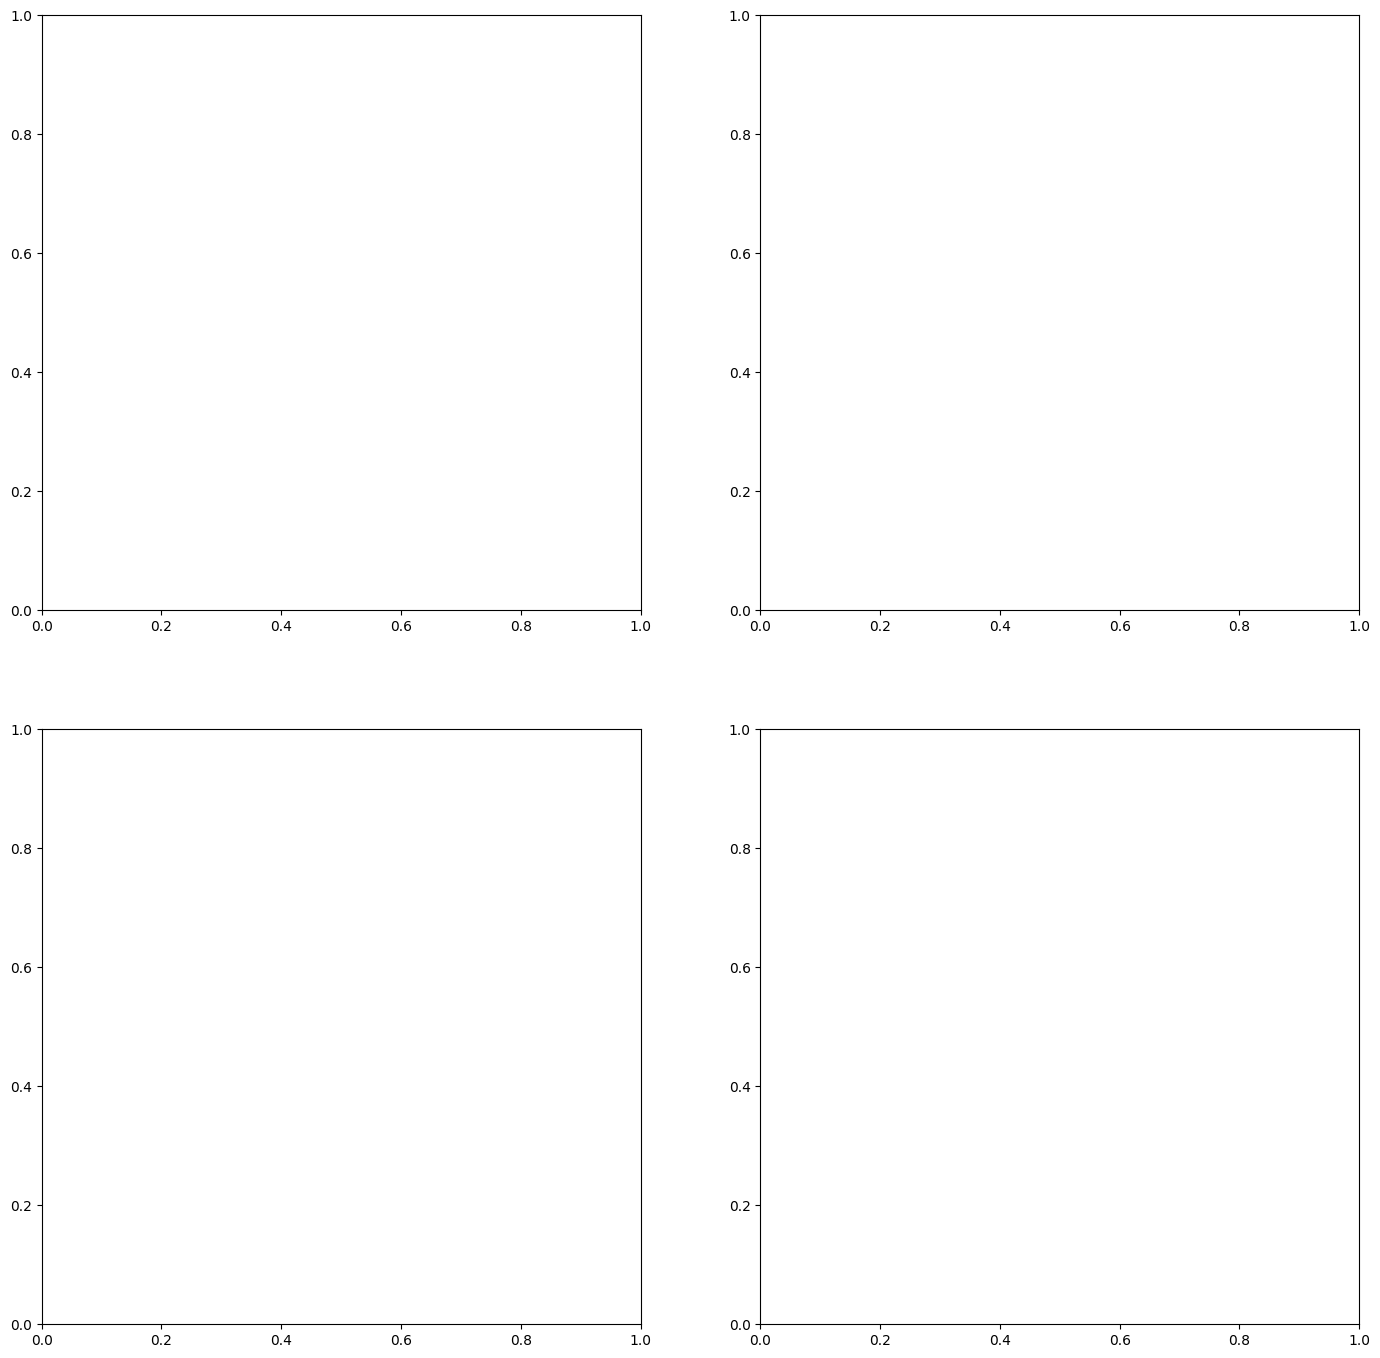

In [27]:
ax, i = init_grid((2,2),(17,17))
cols = ['err-mean', 'percent-matched']
axis_param = [[0.1, 0, 0, 1.01],[0.1, 0, 0,1.01],[0.1, 0, 0, 1.01],[0.1, 0, 0,1.01]]
for vf in [1, 0]:
    dftt = dft[dft["var-fixed"]==vf]
    for col in cols:
        a = dftt.pivot_table(col, index=['n-sources'], columns=['var-val', 'var-fixed'], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i])
        ax[i].legend_.remove()
        a.set_ylim([0,1])
        style_line_plot("", "", grid='x', ax=ax[i])
        adjust_y_axis(*axis_param[i], a)
        i+=1
if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'plot-variance-fixed.tex']),
    figureheight = '\\figureheight',
    figurewidth = '\\figurewidth'
    )

# Analyse DataFrame

### Examine Outliers

In [ ]:
# print(pd.concat([df[df["err-mean"]>=1.5].loc[:, "err1":"err7"], df[df["err-mean"]>=1.5].loc[:, "x1":"x7"]], axis=1))
print("ERRORS:\n{}\n".format(dft[dft["err-mean"]>=1.5].loc[:, "err1":"err7"]))
print("X-COORDINATES:\n{}\n".format(dft[dft["err-mean"]>=1.5].loc[:, "x1":"x7est"]))
print("Y-COORDINATES:\n{}\n".format(dft[dft["err-mean"]>=1.5].loc[:, "y1":"y7est"]))

In [ ]:
# Box Plot
bp = df.boxplot('err-mean', by=["n-sources", "refl-ord"], return_type='both',figsize=(17,  12), showmeans=True, meanline=True)
style_boxplot(bp,None,0,1)

# if EXPORT_LATEX:
#     tikz_save(PATH_BOX_PLOT, show_info=False)

# Perfect Match Analysis

In [ ]:
dfcp = df.pivot_table("percent-matched", columns="refl-ord", aggfunc='mean').transpose()
dfcp.plot(**DEFAULT_LINE_PLOT_ARGS)
# Style plot
style_line_plot(xlabel="number of sources", ylabel="perfect matches", grid="y")